<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [15]</a>'.</span>

## Global signal simulation
_Phil Bull, 2023-01-09_

This notebook uses hera_sim to generate a simple global signal simulation.

In [1]:
import numpy as np
import pylab as plt

import pyuvdata
from pyuvdata import UVData, UVCal
import hera_sim, vis_cpu, pyuvsim
from hera_sim.visibilities import VisibilitySimulation, ModelData, VisCPU

import astropy
from astropy import units as u
from astropy.coordinates import EarthLocation, SkyCoord, AltAz
from astropy.time import Time

import time, json, h5py

import pygdsm
import pyradiosky
import healpy as hp
import astropy_healpix

import matplotlib.patches as patches
plt.rcParams["figure.figsize"] = (10, 5)

## Table of Contents

* [Simulation parameters](#params)
* [Utility functions](#utils)
* [Simple antenna gain model](#gains)
* [Primary beams](#beams)
* [Diffuse emission](#diffuse)
* [Point sources from catalogue](#ptsrc-cat)
* [Synthetic point source catalogue](#ptsrc-synthetic)
* [Simulate point source visibilities](#ptsrc-sim)
* [21cm signal](#21cm)
* [Noise diode](#ndiode)
* [Combined sky and calibrator signals](#skycal)
* [Calibration loads](#loads)
* [Reflections](#reflections)
* [Applying gains](#apply-gains)
* [Save data](#save-data)

<a id='params'></a>
## Simulation parameters

In [2]:
# Frequencies and times
Nfreqs = 280
Ntimes = 3600
dt = 2. # 2 sec
jd = 2459873.83333 # 2022-10-21, 8pm UTC

# Site location
site_lat = 53.235002 # deg
site_lon = -2.3044349 # deg
site_height = 77. # m

# Random seed
random_seed = 4

# Frequency array
freqs = np.linspace(60., 88., Nfreqs) # MHz

# Diffuse model properties
diffuse_sim_nblocks = 5 # chunk in frequency to reduce memory reqs
diffuse_nside = 16 # Diffuse map nside

# Bandpass parameters (Chebyshev)
bandpass_ncoeffs = 50 #12
bandpass_ripple_factor = 0.01
bandpass_rolloff_scale_low = 1.
bandpass_rolloff_scale_high = 1.

# Correlated gain parameters
gain_corr_beta = -1.1
gain_corr_scale = 5.
fknee = 1. / (200.) # 200 sec

# Instrumental noise
Tinstrument = 300. # K

# Noise diode parameters
Tdiode = 60. # K
ndiode_ncoeffs = 20
ndiode_ripple_factor = 0.0005
ndiode_cadence = 10
ndiode_duration = 2
ndiode_gain = 10.
ndiode_bandpass_ncoeffs = 6
ndiode_bandpass_ripple_factor = 0.0005

# Calibration loads
Tload1 = 293. # K
load1_time_ncoeffs = 6
load1_time_amp = 3e-4
load1_freq_ncoeffs = 6
load1_freq_amp = 3e-4

Tload2 = 393. # K
load2_time_ncoeffs = 6
load2_time_amp = 3e-4
load2_freq_ncoeffs = 6
load2_freq_amp = 3e-4

# Noise-wave reflection parameters
Gamma_src_re0 = 0.01
Gamma_src_im0 = 0.01
Gamma_src_time_ncoeffs = 4
Gamma_src_time_amp = 0.5
Gamma_src_freq_ncoeffs = 8
Gamma_src_freq_amp = 0.5

Gamma_rec_re0 = 0.02
Gamma_rec_im0 = 0.02
Gamma_rec_time_ncoeffs = 4
Gamma_rec_time_amp = 0.5
Gamma_rec_freq_ncoeffs = 8
Gamma_rec_freq_amp = 0.5

# Noise-wave temperature parameters
Tunc0 = 250. # K
Tcos0 = 190. # K
Tsin0 = 90. # K
Toffset0 = 0. # K

Tunc_time_ncoeffs = 6
Tunc_time_amp = 1e-2
Tunc_freq_ncoeffs = 6
Tunc_freq_amp = 1e-2

Tcos_time_ncoeffs = 6
Tcos_time_amp = 1e-2
Tcos_freq_ncoeffs = 6
Tcos_freq_amp = 1e-2

Tsin_time_ncoeffs = 6
Tsin_time_amp = 1e-2
Tsin_freq_ncoeffs = 6
Tsin_freq_amp = 1e-2

Toffset_time_ncoeffs = 6
Toffset_time_amp = 1e-2
Toffset_freq_ncoeffs = 6
Toffset_freq_amp = 1e-2

# Output prefix
prefix = "sim_global"

In [3]:
np.random.seed(random_seed)

In [4]:
# Jodrell Bank location
location = EarthLocation.from_geodetic(lat=site_lat,
                                       lon=site_lon,
                                       height=site_height)

# Observation time
obstime = Time(jd, format='jd')
print(obstime.iso)

# Time offsets from 'obstime'
times = np.linspace(0., Ntimes*dt, Ntimes) * u.second

2022-10-21 07:59:59.712


In [5]:
lsts = []
for tt in times:
    frame = AltAz(obstime=obstime + tt, location=location)
    lsts.append((obstime + tt).sidereal_time('apparent', longitude=location.lon).rad)
lsts = np.array(lsts)

In [6]:
# Construct array
ants = {0: [0., 0., 0.]}

<a id='utils'></a>
### Utility functions

In [7]:
def Jy_to_TRJ(flux, freqs, omega):
    """
    Convert data in Jy to units of T_RJ (Kelvin).
    
    Parameters:
        flux (array_like):
            Array of shape (Ntimes, Nfreqs) in Jy units.
        freqs (array_like):
            Frequencies, in MHz.
        omega (array_like):
            Beam solid angle (sterad.) as a function of frequency.
    
    Returns:
        Trj (array_like):
            Input flux array rescale to T_RJ units.
    """
    assert len(flux.shape) == 2, "`flux` must have shape (Ntimes, Nfreqs)"
    assert flux.shape[1] == freqs.size, "`flux` must have shape (Ntimes, Nfreqs)"
    assert omega.size == freqs.size, "`omega' must have shape (Nfreqs,)"
    
    # Define constants
    kB = 1.380649e-23 # m^2 kg s^-2 K^-1
    C = 299792458. # m/s
    
    # Perform conversion
    lam = C / (freqs * 1e6) # wavelength, in m
    fac = lam**2. / (2. * kB * omega) * 1e-26
    Trj = flux * fac[np.newaxis,:]
    return Trj

In [8]:
def chebyshev_model(x, ncoeffs, amp):
    """
    This convenience function produces a Chebyshev series model in 
    frequency/time/etc. to produce a model for various components 
    and systematic effects.
    
    Parameters:
        x (array_like):
            Time/freq. variable.
        ncoeffs (int):
            No. of Chebyshev coefficients to use.
        amp (float):
            Overall amplitude of the Chebyshev polynomial.
    
    Returns:
        fn (array_like):
            Chebyshev function. 
    """
    # Chebyshev parameters
    coeffs = amp * np.random.randn(ncoeffs)

    # Construct time- and frequency-dependent random Chebyshev functions
    xx = np.linspace(-1., 1., x.size)
    fn = np.polynomial.chebyshev.Chebyshev(coeffs)(xx)
    
    # Return values
    return fn

In [9]:
def get_beam_area(beam, freqs, naz=200, nza=300, beam_squared=False):
    
    # Regular grid in azimuth and zenith angle
    _az = np.linspace(0., 2.*np.pi, naz)
    _za = np.linspace(0., 0.5*np.pi, nza)
    az, za = np.meshgrid(_az, _za)
    
    # Get pixel sizes
    pix_az = _az[1] - _az[0]
    pix_za = _za[1] - _za[0]
    
    # Interpolate beam vs frequency
    beam.peak_normalize()
    b, _ = beam.interp(az_array=az.flatten(), za_array=za.flatten(), freq_array=freqs*1e6)
    
    # Reshape to (Nfreqs, Naz, Nza)
    b = b[0,0,1,:,:].copy()
    b = b.reshape((freqs.size, az.shape[0], az.shape[1]))
    if beam_squared:
        b *= b
    
    # Multiply by sin(alt) and then sum to approximate integral
    b *= np.sin(0.5*np.pi - za)[np.newaxis,:,:]
    area = np.sum(b, axis=(1,2)) * (pix_az * pix_za)
    return area

<a id='gains'></a>
### Simple antenna gain model
The gains will be subject to bandpass effects, 1/f noise and so on.

fknee = 5.00 mHz


/tmp/ipykernel_2277624/4192935447.py:6: RuntimeWarning: divide by zero encountered in power
  corr_power = (np.abs(ff) / fknee)**gain_corr_beta


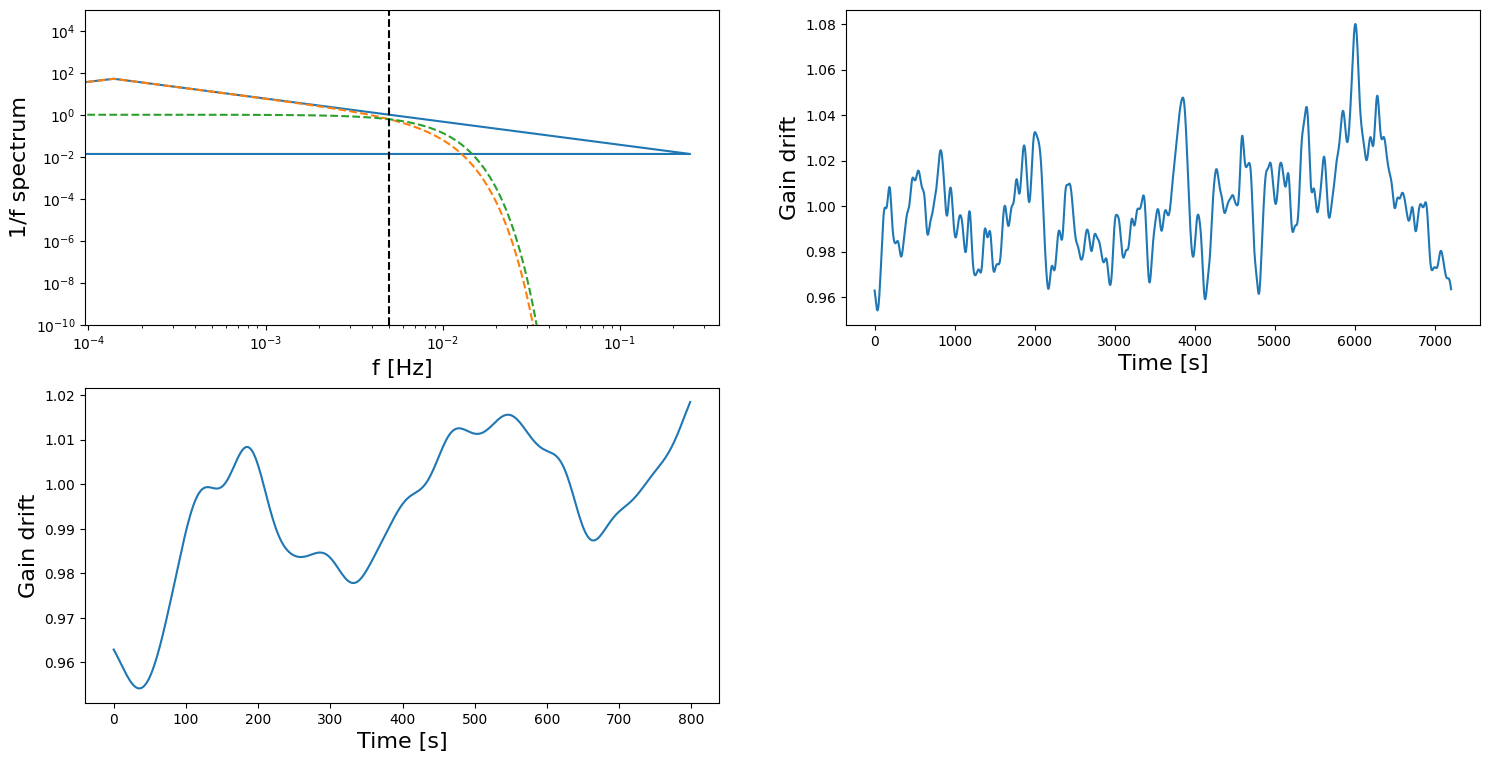

In [10]:
# 1/f noise as gain drifts
print("fknee = %3.2f mHz" % (fknee * 1e3))

# Do FFT on sqrt of power
ff = np.fft.fftfreq(Ntimes, d=dt)
corr_power = (np.abs(ff) / fknee)**gain_corr_beta
corr_power[ff == 0.] = 0.

# Add cutoff above knee frequency, for smoothing
rolloff_scale = fknee # Hz
rolloff = np.exp(-0.5*(np.abs(ff))**2. / rolloff_scale**2.)

# Do FFT of series of ones to get correlated gain rms
nn = np.random.randn(Ntimes) + 1.j*np.random.randn(Ntimes)
gain_corr = 1. + gain_corr_scale * np.fft.ifft(np.sqrt(corr_power*rolloff) * nn).real

# Plot 1/f spectrum
plt.subplot(221)
plt.plot(ff, corr_power)
plt.plot(ff, corr_power*rolloff, ls='dashed')
plt.plot(ff, rolloff, ls='dashed')
plt.axvline(fknee, color='k', ls='dashed')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("f [Hz]", fontsize=16)
plt.ylabel("1/f spectrum", fontsize=16)

plt.ylim((1e-10, 1e5))

# Plot correlated gain drift
plt.subplot(222)
plt.plot(times, gain_corr)
plt.xlabel("Time [s]", fontsize=16)
plt.ylabel("Gain drift", fontsize=16)


# Zoom in on correlated gain drift
plt.subplot(223)
plt.plot(times[:400], gain_corr[:400])
plt.xlabel("Time [s]", fontsize=16)
plt.ylabel("Gain drift", fontsize=16)

plt.gcf().set_size_inches((18., 9.))

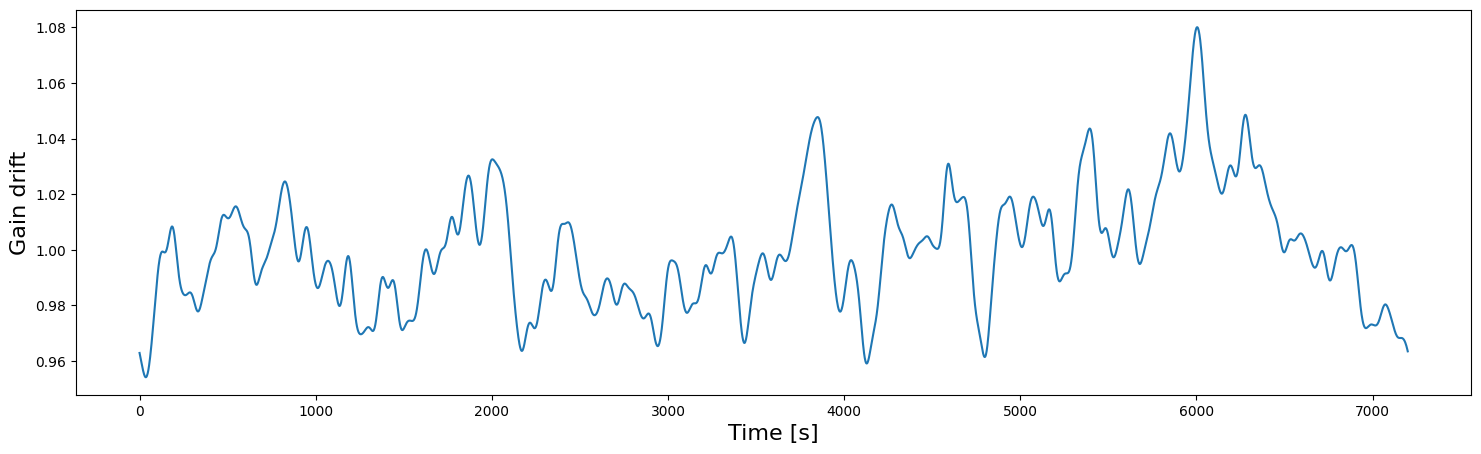

In [11]:
# Plot correlated gain drift in a bigger format
plt.subplot(111)
plt.plot(times, gain_corr)
plt.xlabel("Time [s]", fontsize=16)
plt.ylabel("Gain drift", fontsize=16)

plt.gcf().set_size_inches((18., 5.))

Text(0, 0.5, 'Bandpass')

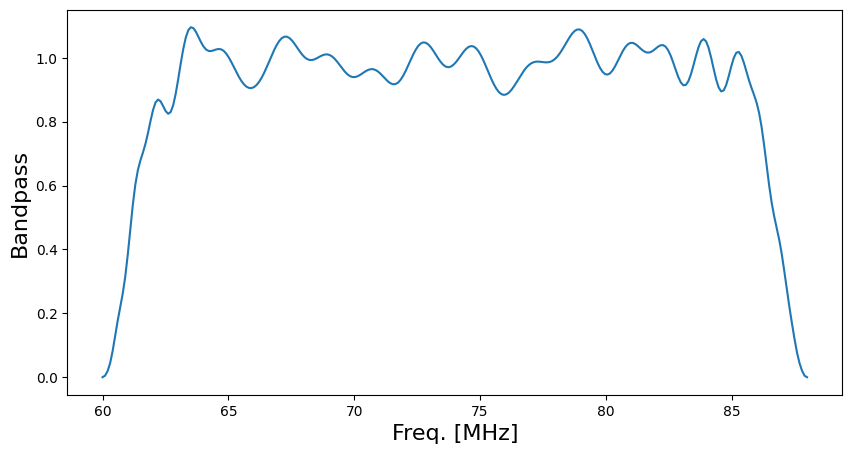

In [12]:
# Bandpass
# Use Chebyshev to simulate some ripples and add a steep roll-off
bandpass_shape = 1. + chebyshev_model(freqs, bandpass_ncoeffs, bandpass_ripple_factor)

# Make band-edge roll-offs
rolloff1 = 1. - np.exp(-0.5*((freqs - freqs[0]) / bandpass_rolloff_scale_low)**2.)
rolloff2 = 1. - np.exp(-0.5*((freqs - freqs[-1]) / bandpass_rolloff_scale_high)**2.)

# Construct bandpass with rolloffs
bandpass = bandpass_shape * rolloff1 * rolloff2

plt.subplot(111)
plt.plot(freqs, bandpass)

plt.xlabel("Freq. [MHz]", fontsize=16)
plt.ylabel("Bandpass", fontsize=16)

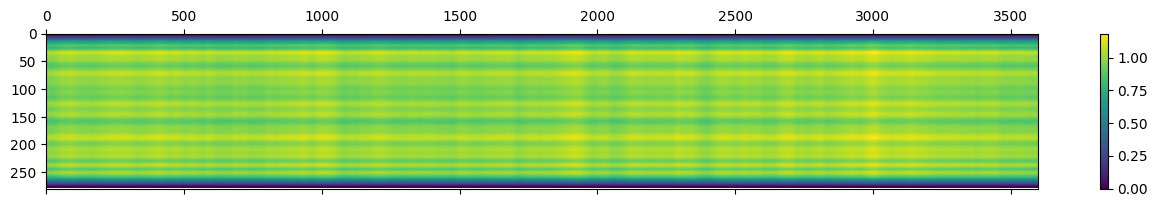

In [13]:
plt.matshow(bandpass[:,np.newaxis] * gain_corr[np.newaxis,:], aspect='auto')
plt.colorbar()

<a id='beams'></a>
## Primary beams
Beam is specified here. Must be UVBeam.

In [14]:
from pyuvsim.simsetup import BeamList
from pyuvdata import UVBeam
import yaml

beam_file = "NF_HERA_Vivaldi_power_beam.fits"                   # BEAM_FILE will be set at pipeline execution time   

beam_list= BeamList([beam_file])
beam_list.set_obj_mode()

with open('beams.yaml', 'r') as file:
    beams = yaml.safe_load(file)

prefix = prefix+"_"+beams[beam_file]     # beam short name

/users/hgarsden/miniconda3/envs/frf_paper/lib/python3.10/site-packages/pyuvsim/telescope.py:168: UserWarning: Cannot check consistency of a string-mode BeamList! Set force=True to force consistency checking.
  warnings.warn(


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [15]:
_az = np.linspace(0., 2.*np.pi, 200)
_za = np.linspace(0., 0.5*np.pi, 300)
az, za = np.meshgrid(_az, _za)

beams[0].peak_normalize()
b,_ = beams[0].interp(az_array=az.flatten(), za_array=za.flatten(), freq_array=np.array([freqs[0]*1e6,]))
beam = b[0,0,1,0,:].reshape(az.shape)

plt.matshow(beam.T, aspect='auto', extent=[np.rad2deg(_za.min()), np.rad2deg(_za.max()), 
                                           np.rad2deg(_az.max()), np.rad2deg(_az.min())])

plt.xlabel("Zenith angle [deg]", fontsize=16.)
plt.ylabel("Azimuth [deg]", fontsize=16.)
plt.colorbar()

KeyError: 0

In [ ]:
plt.plot(np.rad2deg(_za), beam[:,0]**2.)
plt.axhline(0., ls='dashed', color='k')

<a id='diffuse'></a>
## Diffuse emission

In [ ]:
def gsm_sky_model(freqs, resolution="hi", nside=None):
    """
    Return a pyradiosky SkyModel object populated with a Global Sky Model datacube in 
    healpix format.
    Parameters
    ----------
    freqs : array_like
        Frequency array, in Hz.
    resolution : str, optional
        Whether to use the high or low resolution pygdsm maps. Options are 'hi' or 'low'.
    nside : int, optional
        Healpix nside to up- or down-sample the GSM sky model to. Default: `None` (use the 
        default from `pygdsm`, which is 1024).
    Returns
    -------
    sky_model : pyradiosky.SkyModel
        SkyModel object.
    """
    # Initialise GSM object
    gsm = pygdsm.GlobalSkyModel2016(data_unit="TRJ", resolution=resolution, freq_unit="Hz")

    # Construct GSM datacube
    hpmap = gsm.generate(freqs=freqs) # FIXME: nside=1024, ring ordering, galactic coords
    hpmap_units = "K"

    # Set nside or resample
    nside_gsm = int(astropy_healpix.npix_to_nside(hpmap.shape[-1]))
    if nside is None:
        # Use default nside from pygdsm map
        nside = nside_gsm
    else:
        # Transform to a user-selected nside
        hpmap_new = np.zeros((hpmap.shape[0], astropy_healpix.nside_to_npix(nside)), 
                             dtype=hpmap.dtype)
        for i in range(hpmap.shape[0]):
            hpmap_new[i,:] = hp.ud_grade(hpmap[i,:], 
                                         nside_out=nside, 
                                         order_in="RING", 
                                         order_out="RING")
        hpmap = hpmap_new

    # Get datacube properties
    npix = astropy_healpix.nside_to_npix(nside)
    indices = np.arange(npix)
    history = "pygdsm.GlobalSkyModel2016, data_unit=TRJ, resolution=low, freq_unit=MHz"
    freq = u.Quantity(freqs, "hertz")

    # hmap is in K
    stokes = u.Quantity(np.zeros((4, len(freq), len(indices))), hpmap_units)
    stokes[0] = hpmap * u.Unit(hpmap_units)

    # Construct pyradiosky SkyModel
    sky_model = pyradiosky.SkyModel(
                                    nside=nside,
                                    hpx_inds=indices,
                                    stokes=stokes,
                                    spectral_type="full",
                                    freq_array=freq,
                                    history=history,
                                    frame="galactic",
                                    hpx_order="ring"
                                )

    sky_model.healpix_interp_transform(frame='icrs', full_sky=True, inplace=True) # do coord transform
    assert sky_model.component_type == "healpix"
    return sky_model

In [ ]:
def empty_uvdata(ants=None, nfreq=20, ntimes=20, bandwidth=0.2e8, 
                 integration_time=40., 
                 start_time=2458902.33333, start_freq=1.e8, **kwargs):
    """
    Generate empty UVData object with the right shape.
    
    Parameters
    ----------
    ants (dict): None
        A dictionary mapping an integer to a three-tuple of ENU co-ordinates for
        each antenna. These antennas can be down-selected via keywords.
    ntimes : int, optional
        Number of time samples. Default: 20.
    
    bandwidth : float
        Total bandwidth, in Hz. Default: 0.2e8
    
    integration_time : float, optional
        Integration time per time sample. Default: 40. 
    
    start_time : float, optional
        Start date of observations, as Julian date. Default: 2458902.33333 
        (20:00 UTC on 2020-02-22)
    
    start_freq : float, optional
        Initial frequency channel, in Hz. Default: 1.e8.
    
    **kwargs : args
        Other arguments to be passed to `hera_sim.io.empty_uvdata`.
    
    Returns
    -------
    uvd : UVData
        Returns an empty UVData 
    """
    from hera_sim import io
    uvd = io.empty_uvdata(
        Nfreqs=nfreq,
        start_freq=start_freq,
        channel_width=bandwidth / nfreq,
        start_time=start_time,
        integration_time=integration_time,
        Ntimes=ntimes,
        array_layout=ants,
        **kwargs
    )
    
    # Add missing parameters
    uvd._x_orientation.value = 'east'
    return uvd

In [ ]:
def simulate_diffuse(freqs, beam_list, nside=64):
    
    # Construct a data model
    cfg_spec = dict( nfreq=freqs.size,
                     start_freq=freqs[0]*1e6,
                     bandwidth=(freqs[-1]-freqs[0])*1e6,
                     start_time=jd,
                     integration_time=dt,
                     ntimes=Ntimes)
    
    # Prepare empty data structure
    uvd = empty_uvdata(ants=ants, **cfg_spec)
    
    # FIXME: This can use a lot of memory in MPI mode, as there are Nprocs duplicates 
    # of the whole datacube!
    # Build SkyModel from GSM (pygdsm)
    gsm_sky = gsm_sky_model(np.unique(uvd.freq_array), resolution="lo", nside=nside)
    
    # Prepare model
    data_model = ModelData(uvdata=uvd, 
                           sky_model=gsm_sky,
                           beams=beam_list)
    
    # Initialise VisCPU handler object
    viscpu = VisCPU(precision=2)

    # Create a VisibilitySimulation object
    simulator_diffuse = VisibilitySimulation(data_model=data_model, 
                                             simulator=viscpu)
    
    # Run the simulation
    tstart = time.time()
    simulator_diffuse.simulate()
    print("\tSimulation (diffuse) took %2.1f sec" % (time.time() - tstart))
    
    # Get simulated data
    _d = uvd.get_data((0,0))
    
    # Convert from Jy to 
    assert uvd.vis_units == 'Jy'
    return _d


# Simulate in blocks of frequency
d_diffuse = np.zeros((Ntimes, Nfreqs))
nn = Nfreqs // diffuse_sim_nblocks
for i in range(diffuse_sim_nblocks):
    print("Block %d / %d" % (i+1, diffuse_sim_nblocks))
    _d = simulate_diffuse(freqs[nn*i:nn*(i+1)], beam_list=beams, nside=diffuse_nside)
    d_diffuse[:,nn*i:nn*(i+1)] = _d.real

In [ ]:
plt.matshow(d_diffuse.T, aspect='auto')
plt.colorbar()

In [ ]:
# Plot map of diffuse emission
gsm = pygdsm.GlobalSkyModel2016(data_unit="TRJ", resolution='hi', freq_unit="Hz")

# Construct GSM datacube
hpmap = gsm.generate(freqs=freqs[0]*1e6)

In [ ]:
hp.projview(np.log10(hpmap), 
            coord=('G', 'E'), 
            rot=(-180.,0.,0.),
            flip='geo',
            min=3, 
            max=4, 
            graticule=True, 
            graticule_labels=False,
            cb_orientation="vertical",
            projection_type="mollweide")

#plt.axhline(-location.lat.deg, color='w', ls='dotted', lw=1.)
#plt.axvline(location.lat.deg, color='w', ls='dotted', lw=1.)

# Note the differenc ein coordinates between newprojplot and this
rect = patches.Rectangle((np.deg2rad(-60.), 
                          np.deg2rad(location.lat.deg-30.)),                         
                         height=np.deg2rad(60.),  
                         width=np.deg2rad(80.),  
                         ec='w', fc='w', alpha=0.2, zorder=99)
plt.gca().add_patch(rect)
rect = patches.Rectangle((np.deg2rad(-60.), 
                          np.deg2rad(location.lat.deg-30.)),                         
                         height=np.deg2rad(60.),  
                         width=np.deg2rad(80.),  
                         lw=2., ec='w', fc='none', alpha=1., zorder=99)
plt.gca().add_patch(rect)

plt.gcf().set_size_inches((16., 8.))

In [ ]:
hp.projview(np.log10(hpmap), 
            coord=('G', 'E'), 
            rot=(-180.,0.,0.),
            flip='geo',
            min=3, 
            max=4, 
            graticule=True, 
            graticule_labels=False,
            cb_orientation="vertical",
            projection_type="mollweide")

#plt.axhline(-location.lat.deg, color='w', ls='dotted', lw=1.)
#plt.axvline(location.lat.deg, color='w', ls='dotted', lw=1.)

# Note the differenc ein coordinates between newprojplot and this
rect = patches.Rectangle((np.deg2rad(-60.), 
                          np.deg2rad(location.lat.deg-30.)),                         
                         height=np.deg2rad(60.),  
                         width=np.deg2rad(80.),  
                         ec='w', fc='w', alpha=0.6, zorder=99)
plt.gca().add_patch(rect)


rect = patches.Rectangle((np.deg2rad(-60.), 
                          np.deg2rad(78.9424-30.)),                         
                         height=np.deg2rad(41.),  
                         width=np.deg2rad(80.),  
                         ec='r', fc='r', alpha=0.8, zorder=99)
plt.gca().add_patch(rect)

#rect = patches.Rectangle((np.deg2rad(-60.), 
#                          np.deg2rad(location.lat.deg-30.)),                         
#                         height=np.deg2rad(60.),  
#                         width=np.deg2rad(80.),  
#                         lw=2., ec='w', fc='none', alpha=1., zorder=99)
#plt.gca().add_patch(rect)

plt.gcf().set_size_inches((16., 8.))

In [ ]:
hp.cartview(np.log10(hpmap), 
            coord=('G', 'E'), 
            min=3, 
            max=4,
           rot=(-180.,0.,0.),
           flip='geo')
hp.graticule()

plt.axhline(location.lat.deg+30., color='w', ls='dotted', lw=2.2)
plt.axhline(location.lat.deg-30., color='w', ls='dotted', lw=2.2)
plt.axhline(location.lat.deg, color='k', ls='dashed', lw=2.2)


svalbard_lat = 78.9424
plt.axhline(svalbard_lat+30., color='r', ls='dotted', lw=2.2)
plt.axhline(svalbard_lat-30., color='r', ls='dotted', lw=2.2)
plt.axhline(svalbard_lat, color='r', ls='dashed', lw=2.2)


plt.axvline(-60., color='w', ls='dotted', lw=2.2)
plt.axvline(20., color='w', ls='dotted', lw=2.2)


plt.gcf().set_size_inches((16., 8.))

<a id='ptsrc-cat'></a>
## Point sources from catalogue

In [ ]:
#import glob

In [ ]:
# http://www.aoc.nrao.edu/~akimball/radiocat_1.1.shtml#download
#cat_files = glob.glob("/home/phil/hera/radiocat/*.csv")
#cat_files.sort()

In [ ]:
#cat = []
#for i, fname in enumerate(cat_files):
#    print("Loading %d / %d" % (i+1, len(cat_files)))
#    _cat = np.genfromtxt(fname, skip_header=1, delimiter=',')
#    print(_cat.shape)
#    cat.append(_cat.T)

In [ ]:
#cat = np.column_stack(cat)
#cat.shape

In [ ]:
#plt.plot(cat[1], cat[2], 'r,', alpha=0.2)
#plt.gcf().set_size_inches((20., 10.))

<a id='ptsrc-synthetic'></a>
## Synthetic point source catalogue
GLEAM doesn't cover the northern sky well enough, but we can build a synthetic catalogue with similar properties, by resampling it.

In [ ]:
# Load trimmed catalogue
cat_ra, cat_dec, cat_flux0, cat_beta = np.genfromtxt("catBC.txt").T

In [ ]:
# Plot source positions
plt.scatter(cat_ra, cat_dec, s=2.*np.sqrt(10. + cat_flux0))

In [ ]:
# Get approximate effective survey area from 3x standard deviation of RA and Dec
width_ra = 3.*np.std(cat_ra)
width_dec = 3.*np.std(cat_dec)
print(width_ra, width_dec)

# Get number density
cat_numdensity = cat_ra.size / (width_ra * width_dec) # approx. per deg^2
print("Number density: %8.4f / deg^2" % cat_numdensity)

In [ ]:
# Calculate new area, and therefore the number of sources (to match the number density)
ra_min, ra_max = 120., 200. # deg
dec_min, dec_max = 53.235 - 30., 53.235 + 30.
new_area = (ra_max - ra_min) * (dec_max - dec_min) # deg^2
new_Nptsrc = int(new_area * cat_numdensity)
print("New catalogue area: %8.4f deg^2" % new_area)
print("No. sources:", new_Nptsrc)

# Restrict source location on sky (close to zenith pointing)
ptsrc_ra = np.random.uniform(low=ra_min, high=ra_max, size=new_Nptsrc) # degrees
ptsrc_dec = np.random.uniform(low=dec_min, high=dec_max, size=new_Nptsrc) # degrees
ptsrc_dec[ptsrc_dec >= 90.] = 90. - (ptsrc_dec[ptsrc_dec >= 90.] - 90.)

# Select subsample of point sources at random, and use their flux and beta
idxs = np.arange(cat_ra.size)
sampled_idxs = np.random.choice(idxs, size=new_Nptsrc, replace=True)
ptsrc_flux0 = cat_flux0[sampled_idxs]
ptsrc_beta = cat_beta[sampled_idxs]

# Plot source positions in new source catalogue
plt.scatter(ptsrc_ra, ptsrc_dec, s=2.*np.sqrt(10. + ptsrc_flux0))
plt.xlabel("RA [deg]", fontsize=16)
plt.ylabel("Dec [deg]", fontsize=16)

In [ ]:
# Plot histogram
plt.subplot(111)
plt.hist(np.log10(ptsrc_flux0), bins=40)
#plt.yscale('log')
plt.xlabel("$\log_{10} S$ [Jy]", fontsize=16)

In [ ]:
# Plot histogram
plt.subplot(111)
plt.hist(ptsrc_beta, bins=40)
plt.xlabel("Point source spectral index", fontsize=16.)

In [ ]:
# Get altitude and azimuth vs LST
coords = SkyCoord(ra=ptsrc_ra*u.degree, dec=ptsrc_dec*u.degree, frame='icrs')

# Loop over times
alt, az = [], []
for tt in times:
    frame = AltAz(obstime=obstime + tt, location=location)
    _c = coords.transform_to(frame)
    alt.append(_c.alt.deg)
    az.append(_c.az.deg)
print("Done.")
alt = np.array(alt)
az = np.array(az)

# Plot altitude and azimuth vs LST
plt.subplot(121)
plt.plot(lsts*24./(2.*np.pi), alt, color='b', alpha=0.3)
plt.axhspan(xmin=0., xmax=1., ymin=-90., ymax=10., color='k', alpha=0.6)
plt.xlabel("LST [h]", fontsize=16)
plt.ylabel("Alt. [deg]", fontsize=16)
plt.xlim((lsts.min()*24./(2.*np.pi), lsts.max()*24./(2.*np.pi)))
plt.ylim((-90., 90.))

plt.subplot(122)
plt.plot(lsts*24./(2.*np.pi), az, color='r', alpha=0.3)
plt.xlabel("LST [h]", fontsize=16)
plt.ylabel("Az. [deg]", fontsize=16)
plt.xlim((lsts.min()*24./(2.*np.pi), lsts.max()*24./(2.*np.pi)))
plt.ylim((0., 360.))

plt.gcf().set_size_inches((16., 5.))

In [ ]:
# Get RA/Dec track of zenith
zen_ra = []
zen_dec = []
for tt in times:
    zen = SkyCoord(alt=90.*u.deg, az=0.*u.deg, obstime=obstime + tt, location=location, frame='altaz')
    zen_ra.append(zen.icrs.ra.deg)
    zen_dec.append(zen.icrs.dec.deg)
zen_ra = np.array(zen_ra)
zen_dec = np.array(zen_dec)

# Plot locations of sources and zenith in equatorial coords
plt.subplot(111)
plt.scatter(ptsrc_ra, ptsrc_dec, s=5.+(ptsrc_flux0), label="Point sources", alpha=0.7)
plt.scatter(zen_ra, zen_dec, c=lsts, marker='x', label="Zenith", cmap='magma')

# Plot approx. beam FWHM
beam_fwhm = (astropy.constants.c.value/(freqs[0]*1e6) / 8.) * 180./np.pi
print("Beam FWHM: %5.1f deg" % beam_fwhm)
for i in np.arange(zen_ra.size)[::200]:
    circ = patches.Circle((zen_ra[i], zen_dec[i]), beam_fwhm/2., alpha=0.05, fc='gray', zorder=-100)
    plt.gca().add_patch(circ)
    if i % 2 == 0:
        plt.text(zen_ra[i] - 2., zen_dec[i] - 8., "%3.1fh" % (lsts[i]*24./(2.*np.pi)), rotation=45., alpha=0.3)

plt.legend(loc='upper right', frameon=False, prop={'size':'x-large'})
plt.xlabel("RA [deg]", fontsize=16)
plt.ylabel("Dec [deg]", fontsize=16)

#plt.ylim((-45., -15.))
plt.gca().tick_params(which='both', labelsize=16, size=8., width=1.8)

plt.gcf().set_size_inches((14., 7.))

<a id='ptsrc-sim'></a>
## Simulate point source visibilities
We use vis_cpu to simulate the point source visibilities

In [ ]:
# Construct fluxes array by multiplying by powerlaw frequency dependence
fluxes = ptsrc_flux0[:,np.newaxis] * (freqs[np.newaxis,:] / 100.)**ptsrc_beta[:,np.newaxis]

In [ ]:
# Simulate visibilities
t0 = time.time()
ptsrc_vis = vis_cpu.simulate_vis(ants=ants, 
                                 fluxes=fluxes, 
                                 ra=np.deg2rad(ptsrc_ra), 
                                 dec=np.deg2rad(ptsrc_dec), 
                                 freqs=freqs*1e6, 
                                 lsts=lsts, 
                                 beams=beam_list, 
                                 precision=2, 
                                 polarized=False,
                                 latitude=location.lat.rad)
print("Run took %3.1f sec" % (time.time() - t0))

In [ ]:
extent = [lsts.min()*24./(2.*np.pi), lsts.max()*24./(2.*np.pi),
          freqs.max(), freqs.min()]
plt.matshow(np.abs(ptsrc_vis[:,:,0,0]), aspect='auto', extent=extent)
plt.colorbar()
plt.ylabel("Freq. [MHz]", fontsize=16.)
plt.xlabel("LST [h]", fontsize=16.)

In [ ]:
plt.plot(ptsrc_vis[:,0,0,0])

<a id='21cm'></a>
## 21cm signal

In [ ]:
def T21cm_profile(freqs, Tb0=10e-3, centre=75., width=5., depth=100e-3, spindex=4):
    return Tb0 * np.ones_like(freqs) \
          - depth * np.exp(-0.5 * ((freqs-centre)/width)**(2*spindex))

In [ ]:
Tb = T21cm_profile(freqs, Tb0=10e-3, centre=75., width=5., depth=100e-3, spindex=4)

plt.subplot(111)
plt.plot(freqs, Tb)

plt.xlabel("Freqs. [MHz]", fontsize=16)
plt.ylabel("Tb [K]", fontsize=16)

<a id='ndiode'></a>
## Noise diode

**HG** ndiode_signal and ndiode_alwayson are used once each in later sections.

In [ ]:
# Construct random Chebyshev model for noise diode time-dep. amplitude
ndiode_shape = 1. + chebyshev_model(lsts, ndiode_ncoeffs, ndiode_ripple_factor)

# Plot noise diode amplitude
plt.subplot(111)
plt.plot(lsts, ndiode_shape)

In [ ]:
# Noise diode waveform
tt = np.arange(lsts.size) * dt
ndiode_time_signal = np.zeros(tt.size)

# Switch on for given cadence and duration
for i in range(ndiode_duration):
    ndiode_time_signal[i::ndiode_cadence] = 1.
ndiode_time_signal *= ndiode_shape
    
plt.plot(tt, ndiode_time_signal, 'r.')
plt.ylim((0.99, 1.01))

In [ ]:
# Noise diode bandpass
ndiode_bandpass_shape = 1. + chebyshev_model(freqs, ndiode_bandpass_ncoeffs, ndiode_bandpass_ripple_factor)

# Plot noise diode bandpass
plt.subplot(111)
plt.plot(freqs, ndiode_bandpass_shape)

In [ ]:
# Combined noise diode process
ndiode_signal = Tdiode * ndiode_bandpass_shape[np.newaxis,:] * ndiode_time_signal[:,np.newaxis]
ndiode_mask = np.zeros(ndiode_signal.shape)
ndiode_mask[ndiode_signal > 0.] = 1.

# Plot (suffers from aliasing!)
plt.matshow(ndiode_signal.T, aspect='auto') #, vmin=0.95, vmax=1.05)
plt.colorbar()
plt.gcf().set_size_inches((28., 3.))

In [ ]:
plt.matshow(ndiode_mask.T, aspect='auto') #, vmin=0.95, vmax=1.05)
plt.colorbar()
plt.gcf().set_size_inches((28., 3.))

In [ ]:
# Keep a noise diode waterfall that doesn't have the on/off cycles
ndiode_alwayson = Tdiode * ndiode_bandpass_shape[np.newaxis,:] * ndiode_shape[:,np.newaxis]

plt.matshow(ndiode_alwayson.T, aspect='auto')
plt.colorbar()
plt.gcf().set_size_inches((28., 3.))

<a id='skycal'></a>
## Combined sky and calibrator signals

**HG** 
Why "input_signal = sky_signal + noise + ndiode_signal"   why include ndiode_signal.

In [ ]:
# Calculate beam solid angle vs. frequency (use the square of the beam to get the 'power' beam)
omega_beam = get_beam_area(beams[0], freqs, beam_squared=True, naz=500, nza=500)

plt.subplot(111)
plt.plot(freqs, omega_beam)
plt.xlabel("Frequency [MHz]", fontsize=16)
plt.ylabel("Power beam solid angle [ster.]", fontsize=16)

In [ ]:
# Total signal (convert Jy to T_RJ where needed)
sky_signal = Jy_to_TRJ(ptsrc_vis[:,:,0,0].T.real + d_diffuse, 
                       freqs, 
                       omega=omega_beam) \
           + Tb[np.newaxis,:]

In [ ]:
# Plot spectra at single time
plt.subplot(111)
plt.plot(freqs, Jy_to_TRJ(ptsrc_vis[:,:,0,0].T.real, freqs, omega=omega_beam)[20,:], label="Ptsrc.")
plt.plot(freqs, Jy_to_TRJ(d_diffuse, freqs, omega=omega_beam)[20,:], label="Diffuse")
plt.plot(freqs, np.abs(Tb), label="21cm monopole")

plt.legend(loc='upper right')

plt.xlabel("Freq. [MHz]", fontsize=16)
plt.ylabel("|T| [K]", fontsize=16)
plt.yscale('log')
plt.ylim((1e-4, 1e3))

In [ ]:
def noise_realisation(Tsys, freqs, dt):
    """
    Generate a random thermal noise realisation (mean zero) using 
    the radiometer equation, for a given system temperature.
    
    Parameters:
        Tsys (array_like):
            System temperature, in K.
        freqs (array_like):
            Frequency array, in MHz.
        dt (float):
            Integration time per time sample, in sec.
    
    Returns:
        noise (array_like):
            Random noise realisation, in K.
    """
    # Channel bandwidth
    dnu = (freqs[1] - freqs[0]) * 1e6 # Hz
    
    # Noise rms
    sigmaT = Tsys / np.sqrt(dnu * dt)
    
    # Generate noise
    noise = sigmaT * np.random.randn(*Tsys.shape)
    return noise

In [ ]:
# Calculate noise rms using the radiometer equation
noise = noise_realisation(sky_signal + Tinstrument, freqs, dt)

# Plot noise
plt.matshow(noise.T, aspect='auto')
plt.colorbar()

In [ ]:
# Combine signal and noise
input_signal = sky_signal + noise + ndiode_signal
print(input_signal.shape)
plt.matshow(input_signal.T, aspect='auto')
plt.colorbar()

In [ ]:
# Plot input signal at a single time
plt.plot(freqs, input_signal[0])
plt.plot(freqs, input_signal[1])
plt.plot(freqs, input_signal[2])

plt.xlabel("Freq. [MHz]", fontsize=16.)
plt.ylabel("Tobs [K]", fontsize=16.)

In [ ]:
# Plot example time series in a few frequency channels
plt.plot(lsts, input_signal[:,50])
plt.plot(lsts, input_signal[:,60])

plt.plot(lsts, ndiode_signal[:,50])

plt.xlabel("LST [rad]", fontsize=16.)
plt.ylabel("Tobs [K]", fontsize=16.)
plt.gcf().set_size_inches((18., 6.))

In [ ]:
n = 400
plt.plot(lsts[:n], input_signal[:n,50])
plt.plot(lsts[:n], input_signal[:n,120])

plt.xlabel("LST [rad]", fontsize=16.)
plt.ylabel("Tobs [K]", fontsize=16.)
plt.gcf().set_size_inches((18., 6.))

<a id='loads'></a>
## Calibration loads

In [ ]:
# Standard loads with freq./time-dependent ripples
load1_signal = Tload1 \
             * (1. + chebyshev_model(lsts, load1_time_ncoeffs, load1_time_amp)[:,np.newaxis]) \
             * (1. + chebyshev_model(freqs, load1_freq_ncoeffs, load1_freq_amp)[np.newaxis,:])

load2_signal = Tload2 \
             * (1. + chebyshev_model(lsts, load2_time_ncoeffs, load2_time_amp)[:,np.newaxis]) \
             * (1. + chebyshev_model(freqs, load2_freq_ncoeffs, load2_freq_amp)[np.newaxis,:])

In [ ]:
# Generate thermal noise for calibration loads
noise_load1 = noise_realisation(load1_signal + Tinstrument, freqs, dt)
noise_load2 = noise_realisation(load2_signal + Tinstrument, freqs, dt)

In [ ]:
plt.subplot(121)
plt.matshow(load1_signal.T, aspect='auto', fignum=False)
plt.colorbar(label=r"$T_{{\rm load}~1}$ [K]")

plt.subplot(122)
plt.matshow(load2_signal.T, aspect='auto', fignum=False)
plt.colorbar(label=r"$T_{{\rm load}~2}$ [K]")

plt.gcf().set_size_inches((14., 5.))

In [ ]:
# Add noise to calibration load signals
load1 = load1_signal + noise_load1
load2 = load2_signal + noise_load2

In [ ]:
plt.subplot(121)
plt.matshow(load1.T, aspect='auto', fignum=False)
plt.colorbar(label=r"$T_{{\rm load}~1}$ [K]")

plt.subplot(122)
plt.matshow(load2.T, aspect='auto', fignum=False)
plt.colorbar(label=r"$T_{{\rm load}~2}$ [K]")

plt.gcf().set_size_inches((14., 5.))

<a id='reflections'></a>
## Reflections

We use the noise-wave formalism to model the effect of reflections on the measured signal. The model itself is based on Eq. 6 of https://arxiv.org/abs/2011.14052:

$P_{\rm src} = g_{\rm sys} \left [ T_{\rm src} (1 - |\Gamma_{\rm src}|^2) |\kappa|^2 + T_{\rm unc} |\Gamma_{\rm src}|^2 |\kappa|^2 + T_{\rm cos} {\rm Re}(\Gamma_{\rm src} \kappa) + T_{\rm sin} {\rm Im}(\Gamma_{\rm src} \kappa) + T_0 \right ]$
where
$\kappa = \frac{\sqrt{1 - |\Gamma_{\rm rec}|^2}}{1 - \Gamma_{\rm src}\Gamma_{\rm rec}}$.

In [ ]:
prefix = prefix+"_refl"

def apply_noise_wave_params(Tsrc, Gamma_src, Gamma_rec, Tunc, Tcos, Tsin, Toffset):
    """
    Apply the parameters of the noise-wave formalism to an input source temperature.
    Units of the T parameters are K. All quantities are expected to have shape 
    (Ntimes, Nfreqs.)
    
    See Eq. 6 of https://arxiv.org/abs/2011.14052 for definitions.
    
    Parameters:
        Tsrc (array_like):
            True ("calibrated") temperature from the input source.
        Gamma_src (array_like):
            Complex reflection coefficient from the input source.
        Gamma_rec (array_like):
            Complex reflection coefficient to the receiver.
        Tunc (array_like):
            Temperature of the uncorrelated part of the reflection.
        Tcos (array_like):
            Cosine component of the correlated part of the reflection.
        Tsin (array_like):
            Sine component of the correlated part of the reflection.
        Toffset(array_like):
            Overall offset temperature in the signal chain.
    
    Returns:
        Prec (array_like):
            Observed power after passing through the signal chain.
    """
    # Complex kappa factor
    kappa = np.sqrt(1. - np.abs(Gamma_rec)**2.) / (1. - Gamma_src * Gamma_rec)
    
    # Calculate sum of noise wave effects
    Prec = Tsrc * (1. - np.abs(Gamma_src)**2.) * np.abs(kappa)**2. \
         + Tunc * np.abs(Gamma_src)**2. * np.abs(kappa)**2. \
         + Tcos * np.real(Gamma_src * kappa) \
         + Tsin * np.imag(Gamma_src * kappa) \
         + Toffset
    return Prec

In [ ]:
# Gamma is in the range [-1, +1], with 0=no reflection.
Gamma_src_re = Gamma_src_re0 \
             * (1. + chebyshev_model(lsts, Gamma_src_time_ncoeffs, Gamma_src_time_amp)[:,np.newaxis]) \
             * (1. + chebyshev_model(freqs, Gamma_src_freq_ncoeffs, Gamma_src_freq_amp)[np.newaxis,:])

Gamma_src_im = Gamma_src_im0 \
             * (1. + chebyshev_model(lsts, Gamma_src_time_ncoeffs, Gamma_src_time_amp)[:,np.newaxis]) \
             * (1. + chebyshev_model(freqs, Gamma_src_freq_ncoeffs, Gamma_src_freq_amp)[np.newaxis,:])

Gamma_rec_re = Gamma_rec_re0 \
             * (1. + chebyshev_model(lsts, Gamma_rec_time_ncoeffs, Gamma_rec_time_amp)[:,np.newaxis]) \
             * (1. + chebyshev_model(freqs, Gamma_rec_freq_ncoeffs, Gamma_rec_freq_amp)[np.newaxis,:])

Gamma_rec_im = Gamma_rec_im0 \
             * (1. + chebyshev_model(lsts, Gamma_rec_time_ncoeffs, Gamma_rec_time_amp)[:,np.newaxis]) \
             * (1. + chebyshev_model(freqs, Gamma_rec_freq_ncoeffs, Gamma_rec_freq_amp)[np.newaxis,:])

# Combine into complex quantities
Gamma_src = Gamma_src_re + 1.j * Gamma_src_im
Gamma_rec = Gamma_rec_re + 1.j * Gamma_rec_im

In [ ]:
# Plot noise wave reflection parameters
plt.subplot(221)
plt.matshow(Gamma_src_re, aspect='auto', fignum=False)
plt.colorbar(label=r"${\rm Re}(\Gamma_{\rm cal})$")

plt.subplot(222)
plt.matshow(Gamma_src_im, aspect='auto', fignum=False)
plt.colorbar(label=r"${\rm Im}(\Gamma_{\rm cal})$ [K]")

plt.subplot(223)
plt.matshow(Gamma_rec_re, aspect='auto', fignum=False)
plt.colorbar(label=r"${\rm Re}(\Gamma_{\rm rec})$ [K]")

plt.subplot(224)
plt.matshow(Gamma_rec_im, aspect='auto', fignum=False)
plt.colorbar(label=r"${\rm Im}(\Gamma_{\rm rec})$ [K]")

plt.gcf().set_size_inches((14., 6.))

In [ ]:
# See Sect. 3.1 of https://arxiv.org/abs/2011.14052 for representative numbers
T_unc = Tunc0 \
      * (1. + chebyshev_model(lsts, Tunc_time_ncoeffs, Tunc_time_amp)[:,np.newaxis]) \
      * (1. + chebyshev_model(freqs, Tunc_freq_ncoeffs, Tunc_freq_amp)[np.newaxis,:])

T_cos = Tcos0 \
      * (1. + chebyshev_model(lsts, Tcos_time_ncoeffs, Tcos_time_amp)[:,np.newaxis]) \
      * (1. + chebyshev_model(freqs, Tcos_freq_ncoeffs, Tcos_freq_amp)[np.newaxis,:])

T_sin = Tsin0 \
      * (1. + chebyshev_model(lsts, Tsin_time_ncoeffs, Tsin_time_amp)[:,np.newaxis]) \
      * (1. + chebyshev_model(freqs, Tsin_freq_ncoeffs, Tsin_freq_amp)[np.newaxis,:])

T_offset = Toffset0 \
      * (1. + chebyshev_model(lsts, Toffset_time_ncoeffs, Toffset_time_amp)[:,np.newaxis]) \
      * (1. + chebyshev_model(freqs, Toffset_freq_ncoeffs, Toffset_freq_amp)[np.newaxis,:])

In [ ]:
# Plot noise wave temperature parameters
plt.subplot(221)
plt.matshow(T_unc, aspect='auto', fignum=False)
plt.colorbar(label=r"$T_{\rm unc}$ [K]")

plt.subplot(222)
plt.matshow(T_offset, aspect='auto', fignum=False)
plt.colorbar(label=r"$T_{\rm offset}$ [K]")

plt.subplot(223)
plt.matshow(T_cos, aspect='auto', fignum=False)
plt.colorbar(label=r"$T_{\rm cos}$ [K]")

plt.subplot(224)
plt.matshow(T_sin, aspect='auto', fignum=False)
plt.colorbar(label=r"$T_{\rm sin}$ [K]")

plt.gcf().set_size_inches((14., 6.))

In [ ]:
# Apply noise wave effects to sky signal
P_rec = apply_noise_wave_params(Tsrc=input_signal, 
                                Gamma_src=Gamma_src, 
                                Gamma_rec=Gamma_rec, 
                                Tunc=T_unc, 
                                Tcos=T_cos, 
                                Tsin=T_sin, 
                                Toffset=T_offset)

In [ ]:
# Plot input data before and after application of noise wave effects
plt.subplot(221)
plt.matshow(input_signal.T, aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(222)
plt.matshow(P_rec.T, aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(223)
plt.plot(freqs, input_signal.T[:,10])
plt.plot(freqs, P_rec.T[:,10])
plt.colorbar()

plt.subplot(224)
plt.plot(lsts, input_signal.T[10,:], alpha=0.5)
plt.plot(lsts, P_rec.T[10,:], alpha=0.5)
plt.colorbar()

plt.gcf().set_size_inches((16., 8.))

In [ ]:
# Complex kappa factor
kappa = np.sqrt(1. - np.abs(Gamma_rec)**2.) / (1. - Gamma_src * Gamma_rec)

# Calculate sum of noise wave effects
plt.matshow((((1. - np.abs(Gamma_src)**2.) * np.abs(kappa)**2.).T - 1.)*393., aspect='auto')
plt.colorbar()

In [ ]:
# Apply relevant noise-wave prefactor to data and noise diode on their own 
# (so they can be added together if needed)
kappa = np.sqrt(1. - np.abs(Gamma_rec)**2.) / (1. - Gamma_src * Gamma_rec)

# Sky signal + noise + other reflections
P_rec_nodiode = apply_noise_wave_params(Tsrc=sky_signal + noise, 
                                        Gamma_src=Gamma_src, 
                                        Gamma_rec=Gamma_rec, 
                                        Tunc=T_unc, 
                                        Tcos=T_cos, 
                                        Tsin=T_sin, 
                                        Toffset=T_offset)

# Only the noise diode part
P_ndiode = ndiode_alwayson * (1. - np.abs(Gamma_src)**2.) * np.abs(kappa)**2.

In [ ]:
# Apply noise wave effects to calibration loads
# NOTE: We use the approximation that the loads have minimal reflections, 
# so that Gamma_src = 0. We also assume that Gamma_rec is the same as 
# when the antenna is the source.
# FIXME: T_offset can be different
P_load1 = apply_noise_wave_params(Tsrc=load1, 
                                  Gamma_src=0., 
                                  Gamma_rec=Gamma_rec, 
                                  Tunc=0., 
                                  Tcos=0., 
                                  Tsin=0., 
                                  Toffset=T_offset)

P_load2 = apply_noise_wave_params(Tsrc=load2, 
                                  Gamma_src=0., 
                                  Gamma_rec=Gamma_rec, 
                                  Tunc=0., 
                                  Tcos=0., 
                                  Tsin=0., 
                                  Toffset=T_offset)

In [ ]:
# Plot calibrator load 1 before and after application of noise wave effects
plt.subplot(221)
plt.matshow(load1.T, aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(222)
plt.matshow(P_load1.T, aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(223)
plt.plot(freqs, load1.T[:,10])
plt.plot(freqs, P_load1.T[:,10])
plt.colorbar()

plt.subplot(224)
plt.plot(lsts, load1.T[10,:], alpha=0.5)
plt.plot(lsts, P_load1.T[10,:], alpha=0.5)
plt.colorbar()

plt.gcf().set_size_inches((16., 8.))

<a id='apply-gains'></a>
## Applying gains

In [ ]:
# Combined gain factor
gain = bandpass[np.newaxis,:] * gain_corr[:,np.newaxis]

# Plot overall gain
plt.matshow(gain.real.T, aspect='auto')
plt.colorbar()

In [ ]:
# Modulate by receiver gain
data = P_rec * gain
data_load1 = P_load1 * gain
data_load2 = P_load2 * gain

data_nodiode = P_rec_nodiode * gain
data_diode = P_ndiode * gain

In [ ]:
# Plot data after modulation by gains
plt.subplot(511)
plt.matshow(data.T, aspect='auto', fignum=False)
plt.colorbar(label="Recv. power (uncalib.)")

plt.subplot(512)
plt.matshow(data_nodiode.T, aspect='auto', fignum=False)
plt.colorbar(label="Recv. power, no diode (uncalib.)")

plt.subplot(513)
plt.matshow(data_diode.T, aspect='auto', fignum=False)
plt.colorbar(label="Diode power (uncalib.)")

plt.subplot(514)
plt.matshow(data_load1.T, aspect='auto', fignum=False)
plt.colorbar(label="Load 1 power (uncalib.)")

plt.subplot(515)
plt.matshow(data_load2.T, aspect='auto', fignum=False)
plt.colorbar(label="Load 2 power (uncalib.)")

plt.gcf().set_size_inches((20., 15.))

<a id='save-data'></a>
## Save data

In [ ]:
# Save data
with h5py.File("%s.uvh5" % prefix, 'w') as f:
    
    # Store data array
    dset_d = f.create_dataset("data", data=data)
    dset_d.attrs['units'] = 'K'
    dset_d.attrs['obstime'] = str(obstime.iso)
    dset_d.attrs['location'] = str(location)
    dset_d.attrs['site_lat_deg'] = site_lat
    dset_d.attrs['site_lon_deg'] = site_lon
    dset_d.attrs['site_height_m'] = site_height
    
    # Store sky power (with reflection) and noise diode (with 
    # reflection prefactor) separately
    dset_d_nodiode = f.create_dataset("data_nodiode", data=data_nodiode)
    dset_diode = f.create_dataset("data_onlydiode", data=data_diode)
    
    # Store separate calibration load arrays
    dset_dload1 = f.create_dataset("data_load1", data=data_load1)
    dset_dload2 = f.create_dataset("data_load2", data=data_load2)
    
    # Store noise diode mask
    dset_nd = f.create_dataset("ndiode_mask", data=ndiode_mask)
    dset_nd.attrs['Tdiode_Kelvin'] = Tdiode
    
    # Store reflection coefficients
    dset_Gamma_rec = f.create_dataset("data_Gamma_rec", data=Gamma_rec)
    dset_Gamma_src = f.create_dataset("data_Gamma_src", data=Gamma_src)
    
    # Frequency, time, LST arrays
    dset_f = f.create_dataset("freqs", data=freqs)
    dset_f.attrs['units'] = 'MHz'
    
    dset_t = f.create_dataset("times", data=times)
    dset_t.attrs['units'] = 's'
    
    dset_l = f.create_dataset("lsts", data=lsts)
    dset_l.attrs['units'] = 'rad'
    
print("Saved to %s.uvh5" % prefix)

In [ ]:
# Save individual components of simulation
with h5py.File("%s.sim.hdf5" % prefix, 'w') as f:
    
    # Frequency, time, LST arrays
    dset_f = f.create_dataset("freqs", data=freqs)
    dset_f.attrs['units'] = 'MHz'
    dset_t = f.create_dataset("times", data=times)
    dset_t.attrs['units'] = 's'
    dset_l = f.create_dataset("lsts", data=lsts)
    dset_l.attrs['units'] = 'rad'
    
    # Store data array
    dset_d = f.create_dataset("data", data=data)
    dset_d.attrs['units'] = 'K'
    dset_d.attrs['obstime'] = str(obstime.iso)
    dset_d.attrs['location'] = str(location)
    dset_d.attrs['site_lat_deg'] = site_lat
    dset_d.attrs['site_lon_deg'] = site_lon
    dset_d.attrs['site_height_m'] = site_height
    dset_d.attrs['random_seed'] = random_seed
    
    # Store calibration load arrays
    dset_dload1 = f.create_dataset("load1", data=data_load1)
    dset_dload2 = f.create_dataset("load2", data=data_load2)
    
    # Temperature: Diffuse
    dset_diffuse = f.create_dataset("Tdiffuse", data=d_diffuse)
    dset_diffuse.attrs['units'] = 'K'
    
    # Temperature: Point sources
    dset_ptsrc = f.create_dataset("Tptsrc", data=ptsrc_vis)
    dset_ptsrc.attrs['units'] = 'K'
    
    # Temperature: 21cm brightness temperature
    dset_tb = f.create_dataset("Tb21", data=Tb)
    dset_tb.attrs['units'] = 'K'
    
    # Input sky + diode data
    dset_input = f.create_dataset("input_signal", data=input_signal)
    
    # Point source catalogue
    dset_ps_ra = f.create_dataset("ptsrc_ra", data=ptsrc_ra)
    dset_ps_ra.attrs['units'] = 'deg'
    dset_ps_dec = f.create_dataset("ptsrc_dec", data=ptsrc_dec)
    dset_ps_dec.attrs['units'] = 'deg'
    dset_ps_flux0 = f.create_dataset("ptsrc_flux0", data=ptsrc_flux0)
    dset_ps_flux0.attrs['units'] = 'Jy'
    dset_ps_flux0.attrs['ref_freq_MHz'] = 100.
    dset_ps_beta = f.create_dataset("ptsrc_beta", data=ptsrc_beta)
    
    # Beam
    dset_beam = f.create_dataset("beam", data=beam)
    dset_beam.attrs['type'] = beams[0].type
    dset_beam_az = f.create_dataset("beam_az", data=az)
    dset_beam_az.attrs['units'] = 'deg'
    dset_beam_za = f.create_dataset("beam_za", data=za)
    dset_beam_za.attrs['units'] = 'deg'
    
    # Bandpass
    dset_bandpass = f.create_dataset("bandpass", data=bandpass)
    dset_bandpass.attrs['bandpass_ncoeffs'] = bandpass_ncoeffs
    dset_bandpass.attrs['bandpass_ripple_factor'] = bandpass_ripple_factor
    dset_bandpass.attrs['bandpass_rolloff_scale_low'] = bandpass_rolloff_scale_low
    dset_bandpass.attrs['bandpass_rolloff_scale_high'] = bandpass_rolloff_scale_high
    
    # Time-dep. gains
    dset_gain_corr = f.create_dataset("gain_corr", data=gain_corr)
    dset_gain_corr.attrs['gain_corr_beta'] = gain_corr_beta
    dset_gain_corr.attrs['gain_corr_scale'] = gain_corr_scale
    dset_gain_corr.attrs['gain_corr_fknee'] = fknee
    
    # Noise diode data
    dset_nd = f.create_dataset("ndiode_signal", data=ndiode_signal)
    dset_nd.attrs['Tdiode_Kelvin'] = Tdiode
    dset_nd.attrs['ndiode_ripple_factor'] = ndiode_ripple_factor
    dset_nd.attrs['ndiode_cadence'] = ndiode_cadence
    dset_nd.attrs['ndiode_duration'] = ndiode_duration
    dset_nd.attrs['ndiode_gain'] = ndiode_gain
    #dset_ndbp = f.create_dataset("ndiode_bandpass_coeffs", data=ndiode_bandpass_coeffs)
    dset_nds = f.create_dataset("ndiode_shape", data=ndiode_shape)
    dset_nds.attrs['ndiode_bandpass_ripple_factor'] = ndiode_bandpass_ripple_factor
    #dset_ndc = f.create_dataset("ndiode_coeffs", data=ndiode_coeffs)
    
    # Calibration loads
    dset_load1 = f.create_dataset("load1_signal", data=load1_signal)
    dset_load1.attrs['Tload1_Kelvin'] = Tload1
    dset_load1.attrs['load1_time_ncoeffs'] = load1_time_ncoeffs
    dset_load1.attrs['load1_freq_ncoeffs'] = load1_freq_ncoeffs
    dset_load1.attrs['load1_time_amp'] = load1_time_amp
    dset_load1.attrs['load1_freq_amp'] = load1_freq_amp
    
    dset_load2 = f.create_dataset("load2_signal", data=load2_signal)
    dset_load2.attrs['Tload2_Kelvin'] = Tload2
    dset_load2.attrs['load2_time_ncoeffs'] = load2_time_ncoeffs
    dset_load2.attrs['load2_freq_ncoeffs'] = load2_freq_ncoeffs
    dset_load2.attrs['load2_time_amp'] = load2_time_amp
    dset_load2.attrs['load2_freq_amp'] = load2_freq_amp
    
    # Calibration loads after reflections and noise added
    dset_Pload1 = f.create_dataset("Pload1", data=P_load1)
    dset_Pload2 = f.create_dataset("Pload2", data=P_load2)
    
    # Reflection coefficients
    dset_refl_Gamma_src = f.create_dataset("Gamma_src", data=Gamma_src)
    dset_refl_Gamma_src.attrs['Gamma_src_re0'] = Gamma_src_re0
    dset_refl_Gamma_src.attrs['Gamma_src_im0'] = Gamma_src_im0
    dset_refl_Gamma_src.attrs['Gamma_src_time_ncoeffs'] = Gamma_src_time_ncoeffs
    dset_refl_Gamma_src.attrs['Gamma_src_freq_ncoeffs'] = Gamma_src_freq_ncoeffs
    dset_refl_Gamma_src.attrs['Gamma_src_time_amp'] = Gamma_src_time_amp
    dset_refl_Gamma_src.attrs['Gamma_src_freq_amp'] = Gamma_src_freq_amp
    
    dset_refl_Gamma_rec = f.create_dataset("Gamma_rec", data=Gamma_rec)
    dset_refl_Gamma_rec.attrs['Gamma_rec_re0'] = Gamma_rec_re0
    dset_refl_Gamma_rec.attrs['Gamma_rec_im0'] = Gamma_rec_im0
    dset_refl_Gamma_rec.attrs['Gamma_rec_time_ncoeffs'] = Gamma_rec_time_ncoeffs
    dset_refl_Gamma_rec.attrs['Gamma_rec_freq_ncoeffs'] = Gamma_rec_freq_ncoeffs
    dset_refl_Gamma_rec.attrs['Gamma_rec_time_amp'] = Gamma_rec_time_amp
    dset_refl_Gamma_rec.attrs['Gamma_rec_freq_amp'] = Gamma_rec_freq_amp
    
    # Noise-wave temperature coefficients
    dset_refl_Tunc = f.create_dataset("noisewave_Tunc", data=T_unc)
    dset_refl_Tunc.attrs['Tunc0_Kelvin'] = Tunc0
    dset_refl_Tunc.attrs['Tunc_time_ncoeffs'] = Tunc_time_ncoeffs
    dset_refl_Tunc.attrs['Tunc_freq_ncoeffs'] = Tunc_freq_ncoeffs
    dset_refl_Tunc.attrs['Tunc_time_amp'] = Tunc_time_amp
    dset_refl_Tunc.attrs['Tunc_freq_amp'] = Tunc_freq_amp
    
    dset_refl_Tcos = f.create_dataset("noisewave_Tcos", data=T_unc)
    dset_refl_Tcos.attrs['Tcos0_Kelvin'] = Tcos0
    dset_refl_Tcos.attrs['Tcos_time_ncoeffs'] = Tcos_time_ncoeffs
    dset_refl_Tcos.attrs['Tcos_freq_ncoeffs'] = Tcos_freq_ncoeffs
    dset_refl_Tcos.attrs['Tcos_time_amp'] = Tcos_time_amp
    dset_refl_Tcos.attrs['Tcos_freq_amp'] = Tcos_freq_amp
    
    dset_refl_Tsin = f.create_dataset("noisewave_Tsin", data=T_sin)
    dset_refl_Tsin.attrs['Tsin0_Kelvin'] = Tsin0
    dset_refl_Tsin.attrs['Tsin_time_ncoeffs'] = Tsin_time_ncoeffs
    dset_refl_Tsin.attrs['Tsin_freq_ncoeffs'] = Tsin_freq_ncoeffs
    dset_refl_Tsin.attrs['Tsin_time_amp'] = Tsin_time_amp
    dset_refl_Tsin.attrs['Tsin_freq_amp'] = Tsin_freq_amp
    
    dset_refl_Toffset = f.create_dataset("noisewave_Toffset", data=T_offset)
    dset_refl_Toffset.attrs['Toffset0_Kelvin'] = Toffset0
    dset_refl_Toffset.attrs['Toffset_time_ncoeffs'] = Toffset_time_ncoeffs
    dset_refl_Toffset.attrs['Toffset_freq_ncoeffs'] = Toffset_freq_ncoeffs
    dset_refl_Toffset.attrs['Toffset_time_amp'] = Toffset_time_amp
    dset_refl_Toffset.attrs['Toffset_freq_amp'] = Toffset_freq_amp
    
print("Saved to %s.sim.hdf5" % prefix)

In [ ]:
ls -lh *.hdf5

### More complicated beam